In [1]:
import h5py
import sys
import umap

import itertools as it
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

sys.path.append("./cell_pipeline")
sys.path.append("./cox_cross_validation")

from cell_pipeline.hdf5_reader import (
    extract_sample_differential_counts,
    extract_sample_cell_statistics,
    extract_sample_raw_cell_statistics,
    get_target_columns
)
from cell_pipeline.feature_engineering import calculate_percentage_values
from cell_pipeline.constants import CELL_LINEAGES

from cox_cross_validation.cross_validate import elasticnet_cox

from warnings import simplefilter

simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
simplefilter(action="ignore", category=FutureWarning)

toy_path = "./toy_data.hdf5"
samples = [f"Sample_{i}" for i in range(1, 101)]

/home/henri/miniconda3/envs/test/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 0.5. UMAP check

In [2]:
cells = pd.DataFrame()

with h5py.File(toy_path) as file:
    for sample_id in samples:
        stats = extract_sample_raw_cell_statistics(file[sample_id])
        cells = pd.concat([cells, stats]).reset_index(drop=True)

/home/henri/miniconda3/envs/test/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


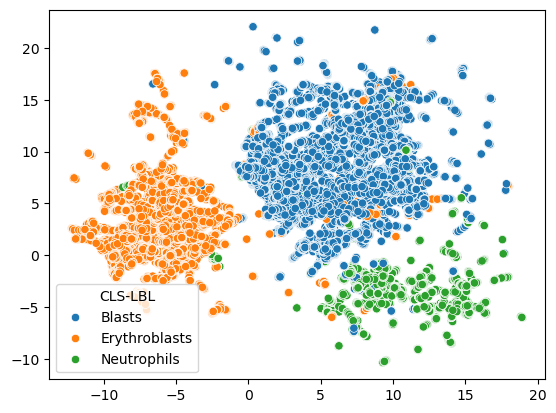

In [3]:
cell_stats = ["cell-area", "cell-perimeter", "cell-nc-ratio",
              "cell-eccentricity", "cell-solidity", "cell-convexity",
              "cytoplasm-area", "nuclei-area", "nuclei-perimeter", 
              "nuclei-eccentricity", "nuclei-solidity", "nuclei-convexity"]

mapper = umap.UMAP(n_neighbors=30, min_dist=0.25, metric="cosine", random_state=10)
# With cell statistics utilized in the analysis
embedding = mapper.fit_transform(StandardScaler().fit_transform(cells.loc[:,cell_stats]))

ax = sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=cells["CLS-LBL"])

### Step 1. Construct cell differential and calculate aggregate statistics from the individual cells

In [4]:
all_results_df = pd.DataFrame(columns=get_target_columns())
all_stats_df = pd.DataFrame()

with h5py.File(toy_path) as file:
    for sample_id in samples:
        # 100x differential
        result_table = extract_sample_differential_counts(file[sample_id])
        result_table = result_table.reindex(
            columns=get_target_columns(), fill_value=0
        )
        all_results_df = pd.concat([all_results_df, result_table], axis=0, ignore_index=True)

        # 100x statistics
        statistic_table = extract_sample_cell_statistics(file[sample_id])
        all_stats_df = pd.concat([all_stats_df, statistic_table], axis=0, ignore_index=True)

# Percentages, feature engineering
all_results_df = calculate_percentage_values(all_results_df)

# Combine
full_df = pd.concat([all_results_df.reset_index(drop=True),
                     all_stats_df.reset_index(drop=True)],
                     axis=1)
full_df.index = samples
full_df.to_csv("aggregated_toy_data.csv")

In [7]:
# Read data
full_df = pd.read_csv("aggregated_toy_data.csv", index_col=0)
full_df

,APL-Class=Abnormal,APL-Class=Abnormal_Percentage,APL-Class=Hypergranular,APL-Class=Hypergranular_Percentage,APL-Class=Inclusion,APL-Class=Inclusion_Percentage,All cells,Artefacts,Artefacts_Percentage,Basophils,...,Neutrophils_nuclei-glcm-energy-1_median,Neutrophils_nuclei-glcm-energy-1_95_range,Neutrophils_nuclei-glcm-energy-2_median,Neutrophils_nuclei-glcm-energy-2_95_range,Neutrophils_nuclei-glcm-energy-3_median,Neutrophils_nuclei-glcm-energy-3_95_range,Neutrophils_nuclei-glcm-energy-4_median,Neutrophils_nuclei-glcm-energy-4_95_range,Neutrophils_nuclei-glcm-energy-5_median,Neutrophils_nuclei-glcm-energy-5_95_range
Sample_1,41,8.559499,0,0.000000,31,6.471816,497,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_2,25,8.503401,0,0.000000,25,8.503401,463,0,0.0,0,...,0.120215,0.029862,0.096001,0.026042,0.086267,0.022598,0.076297,0.019694,0.072727,0.017354
Sample_3,38,9.669211,0,0.000000,92,23.409669,500,0,0.0,0,...,0.109733,0.001646,0.086559,0.001507,0.078459,0.001244,0.070803,0.001155,0.068833,0.001508
Sample_4,35,10.835913,0,0.000000,64,19.814241,500,0,0.0,0,...,0.111962,0.022967,0.089153,0.019625,0.081501,0.017939,0.073795,0.016663,0.071221,0.016892
Sample_5,51,18.149466,0,0.000000,15,5.338078,495,0,0.0,0,...,0.100272,0.042317,0.080853,0.035322,0.073085,0.032792,0.065200,0.026339,0.061254,0.024083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_96,37,12.292359,46,15.282392,0,0.000000,500,0,0.0,0,...,0.127773,0.042714,0.100954,0.032822,0.091541,0.032965,0.079655,0.030333,0.075667,0.030134
Sample_97,29,19.594595,37,25.000000,0,0.000000,453,0,0.0,0,...,0.124925,0.027070,0.099979,0.023572,0.089492,0.021039,0.079184,0.017249,0.076003,0.016297
Sample_98,117,25.161290,9,1.935484,0,0.000000,500,0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sample_99,150,37.128713,0,0.000000,0,0.000000,461,0,0.0,0,...,0.102376,0.003395,0.081276,0.002901,0.074656,0.001846,0.066803,0.001498,0.065279,0.003762


In [ ]:
# All cells != 500 cells for each sample because the differential
# uses the erythroblast quality filter and the "keepval" filter
full_df[["All cells", "Living cells", "n_cells_in_stat_calculations"]]

,All cells,Living cells,n_cells_in_stat_calculations
Sample_1,497,497,328
Sample_2,463,463,291
Sample_3,500,500,314
Sample_4,500,500,321
Sample_5,495,495,376
...,...,...,...
Sample_96,500,500,258
Sample_97,453,453,222
Sample_98,500,500,230
Sample_99,461,461,255


### Step 2. Filter features

The previous step produces a variety of features useful for analytic purposes and/or for exploratory analysis. However, before we start looking for biomarkers, we need to remove some (in fact, most) features as they are (1) not suitable/sensible to be candidate biomarkers or (2) we have detected significant technical artefact in the variable across hospitals, scanners and/or scanner-settings or (3) there are not enough cells of a type in a sample to warrant calculating a robust summary feature

In [9]:
# The example toy data only includes three types of cells
cell_types = ["Blasts", "Erythroblasts", "Neutrophils"]

# Remove compactness and roundness as they are highly collinear with other shape features
c_shapes = ["compactness", "roundness"]
component = ["cell", "nuclei"]
aggs = ["median", "95_range"]
cols = [f"{ct}_{com}-{feat}_{agg}" for (ct, com, feat, agg) in list(it.product(*[cell_types, component, c_shapes, aggs]))]
qua_df = full_df.drop(cols, axis=1)

# We did not end up using colors or GLCM features in the final analysis
qua_df = qua_df.drop(qua_df.filter(like="glcm").columns, axis=1)

red = qua_df.filter(like="-red-").columns
green = qua_df.filter(like="-green-").columns
blue = qua_df.filter(like="-blue-").columns
lumi = qua_df.filter(like="-luminance").columns

qua_df = qua_df.drop(np.concatenate([red, green, blue, lumi]), axis=1)

In [10]:
cell_classes = ["Basophils", "Blasts", "Eosinophils", "Erythroblasts",
                "Lymphocytes", "Megakaryocytes", "Metamyelocytes",
                "Monocytes", "Myelocytes", "Neutrophils", "Plasma cells",
                "Proerythroblasts", "Promyelocytes", "Promonocytes",
                "Macrophages"]

# Cell statistics are aggregated into the median and 95% range by statistic and cell type
# If there are a very small amount of cell of a type, these aggregate statistics
# will not be very informative.

# We require at minimum 20 cells of a type in a sample to calculate the aggregate statistics
ct_in_stat_calculations = [f"{ct}_in_stats_calculations" for ct in cell_classes]
rare_cell = qua_df.loc[:,ct_in_stat_calculations] < 20

# Set all statistics for a cell type to None for samples where the detection number is under 20
for ct in ct_in_stat_calculations:
    is_rare = rare_cell[ct]
    to_mask = is_rare[is_rare].index

    # Only mast statistics columns of the cell type
    ct_columns = qua_df.loc[:,"Blasts_cell-area_median":].filter(like=ct.split("_")[0], axis=1).columns
    qua_df.loc[to_mask, ct_columns] = None
    

In [11]:
other_absolute_counts = ["Unknowns", "Unknowns_Percentage", "Sample",
                         "Artefacts", "Artefacts_Percentage", "Living cells",
                         "All cells", "Erythropoietic cells", "Granulopoietic cells",
                         "Living cells_Percentage", "n_cells_in_stat_calculations"]
qua_df = qua_df.drop(other_absolute_counts, axis=1)

# Similarly to before, the percentage of vacuolization or multinuclarity is not interesting
# if the number of cells is very low, use the same threshold as before (20).
for cell_lineage in CELL_LINEAGES:
    if cell_lineage not in ["Artefacts", "Unknowns", "Living cells"]:
        msk = qua_df.loc[:,f"Vacuolated {cell_lineage}"] < 20
        qua_df.loc[msk,f"Vacuolated {cell_lineage}_Percentage"] = None

        msk = qua_df.loc[:,f"Multinuclear {cell_lineage}"] < 20
        qua_df.loc[msk,f"Multinuclear {cell_lineage}_Percentage"] = None

# If there are under 20 of a cell type, do not consider the percentage reliable
for ct in cell_classes:
    msk = qua_df.loc[:,ct] < 20
    qua_df.loc[msk,f"{ct}_Percentage"] = None

# In general, we do not expect the absolute cell counts to be interesting
qua_df = qua_df.drop(cell_classes, axis=1)

# Also drop other features of absolute counts
results_absolutes = ["APL-Class=Abnormal", "APL-Class=Hypergranular", "APL-Class=Inclusion",
                     "Erythroblasts-Class=Abnormal cytoplasm", "Erythroblasts-Class=Dysmorphic",
                     "Erythroblasts-Class=Megaloblastic", "Erythroblasts-Class=Multinuclear",
                     "Granulocytes-Quality=Low", "Granulocytes-Quality=Normal",
                     "Granulopoietic cells-Granularity=High", "Granulopoietic cells-Granularity=Low",
                     "Granulopoietic cells-Granularity=Normal", "Megakaryocytes-Class=Broken",
                     "Megakaryocytes-Class=Dysplastic", "Megakaryocytes-Class=Hypolobulated",
                     "Megakaryocytes-Class=Multinuclear", "Megakaryocytes-Class=Normal",
                     "Multinuclear Blasts", "Multinuclear Erythropoietic cells", "Multinuclear Granulopoietic cells",
                     "Multinuclear Lymphocytes", "Multinuclear Megakaryocytes",
                     "Multinuclear Monocytic cells", "Multinuclear Plasma cells",
                     "Vacuolated Blasts", "Vacuolated Erythropoietic cells",
                     "Vacuolated Granulopoietic cells", "Vacuolated Lymphocytes", "Vacuolated Megakaryocytes",
                     "Vacuolated Monocytic cells", "Vacuolated Plasma cells",
                     "Eosinophils-Maturation=Immature", "Eosinophils-Maturation=Mature"]

qua_df = qua_df.drop(results_absolutes, axis=1)

# Drop features only really useful for doublechecking sample qualityy
qua_df = qua_df.drop(["Granulocytes-Quality=Low_Percentage", "Granulocytes-Quality=Normal_Percentage"], axis=1)

In [12]:
# After the previous step, it might be that some features have many missing values
# If over 25% values are missing, we remove the feature
nan_counts = qua_df.isna().sum(axis=0)
qua_df = qua_df.drop(nan_counts[nan_counts > 0.25*qua_df.shape[0]].index, axis=1)

# Drop the helper columns
qua_df = qua_df.drop(ct_in_stat_calculations, axis=1)

### Add some simulated PFS times and do the cross-validation procedure

In [29]:
# Add some survival times and treatment statuses to simulate a survival analysis
PFS_times = np.round(np.random.exponential(scale=365, size=100)).astype(int)
PFS_times[PFS_times < 60] = 1

PFS_event = np.random.binomial(1, 0.75, 100).astype(bool)
PFS_event[PFS_times == 1] = True

treatment_status = np.random.binomial(1, 0.50, 100)
PFS_df = pd.DataFrame({"PFS_time_days": PFS_times, "PFS_event": PFS_event, "Arm": treatment_status}, index=qua_df.index)

data_df = PFS_df.merge(qua_df, how="inner", left_index=True, right_index=True)
data_df

,PFS_time_days,PFS_event,Arm,APL-Class=Abnormal_Percentage,APL-Class=Hypergranular_Percentage,APL-Class=Inclusion_Percentage,Blasts_Percentage,Erythroblasts-Class=Abnormal cytoplasm_Percentage,Erythroblasts-Class=Dysmorphic_Percentage,Erythroblasts-Class=Megaloblastic_Percentage,...,Erythroblasts_nuclei-eccentricity_median,Erythroblasts_nuclei-eccentricity_95_range,Blasts_nuclei-solidity_median,Blasts_nuclei-solidity_95_range,Erythroblasts_nuclei-solidity_median,Erythroblasts_nuclei-solidity_95_range,Blasts_nuclei-perimeter_median,Blasts_nuclei-perimeter_95_range,Erythroblasts_nuclei-perimeter_median,Erythroblasts_nuclei-perimeter_95_range
Sample_1,1,True,0,8.559499,0.000000,6.471816,96.378270,33.333333,0.0,0.000000,...,NaN,NaN,0.993122,0.062766,NaN,NaN,364.82666,122.847610,NaN,NaN
Sample_2,1227,True,1,8.503401,0.000000,8.503401,63.498920,57.291667,0.0,28.125000,...,0.562751,0.351016,0.999513,0.061446,1.005120,0.039598,375.70016,182.184479,263.59866,143.028683
Sample_3,235,False,1,9.669211,0.000000,23.409669,78.600000,0.000000,0.0,0.000000,...,NaN,NaN,0.997429,0.060052,NaN,NaN,387.78113,182.008739,NaN,NaN
Sample_4,166,True,1,10.835913,0.000000,19.814241,64.600000,0.000000,0.0,0.000000,...,NaN,NaN,0.994966,0.134004,NaN,NaN,395.71640,268.923923,NaN,NaN
Sample_5,574,False,1,18.149466,0.000000,5.338078,56.767677,8.152174,0.0,7.608696,...,0.463097,0.455707,0.989599,0.121097,1.015741,0.036547,415.11563,266.917101,199.46428,276.895657
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_96,537,True,0,12.292359,15.282392,0.000000,60.200000,0.000000,0.0,0.000000,...,0.287873,0.275779,1.000283,0.067138,1.018822,0.030872,333.47380,123.954826,170.59642,98.840927
Sample_97,453,True,1,19.594595,25.000000,0.000000,32.671082,14.482759,0.0,20.689655,...,0.312387,0.334248,0.999065,0.055798,1.018886,0.029783,340.47202,260.562595,199.62054,122.761515
Sample_98,443,False,1,25.161290,1.935484,0.000000,93.000000,0.000000,0.0,0.000000,...,NaN,NaN,0.990676,0.083269,NaN,NaN,363.05210,187.354490,NaN,NaN
Sample_99,177,False,1,37.128713,0.000000,0.000000,87.635575,0.000000,0.0,0.000000,...,NaN,NaN,0.996037,0.052743,NaN,NaN,366.74658,154.441526,NaN,NaN


In [30]:
# Evaluate AUC C/D with resprect to t=2 and the 25th and 75th percentiles of uncensored event times
ts = np.percentile(data_df[data_df["PFS_event"]].loc[:,"PFS_time_days"], q=[25, 75])
ts = np.concatenate([[2, *ts]])

In [31]:
x = data_df.loc[:,"Arm":]
y = np.core.records.fromrecords(data_df.loc[:,["PFS_event", "PFS_time_days"]].values)
enet_iters = 100 # may take a while, can reduce

enet_results = elasticnet_cox(
    x=x,
    y=y,
    eval_ts=ts,
    k_cv=3,
    iters=enet_iters,
    alphas=[[a] for a in np.arange(0.03, 0.06, 0.01)],
    l1_ratio=[np.round(x, 2) for x in np.arange(0.825, 0.950, 0.05)],
    k=[15, 20, 25, 30]
)

In [35]:
scores = {i: enet_results[i]["test_score"] for i in np.arange(enet_iters)}
score_df = pd.DataFrame(scores).T

# Mean AUC C/Ds over the three timepoints
print(f"AUC C/D over {enet_iters} iterations, median {np.round(score_df.mean(axis=1).median(), 3)}\
 min: {np.round(score_df.mean(axis=1).min(), 3)}, max: {np.round(score_df.mean(axis=1).max(), 3)}")

AUC C/D over 100 iterations, median 0.476 min: 0.36, max: 0.598


Unsurprisingly, as the cells in the "samples" are randomly picked from the real data and jittered, and the PFS times are simulated, the mean AUC C/Ds in the cross-validation routine are near 0.5 meaning that the procedure is not finding any patterns to predict PFS.

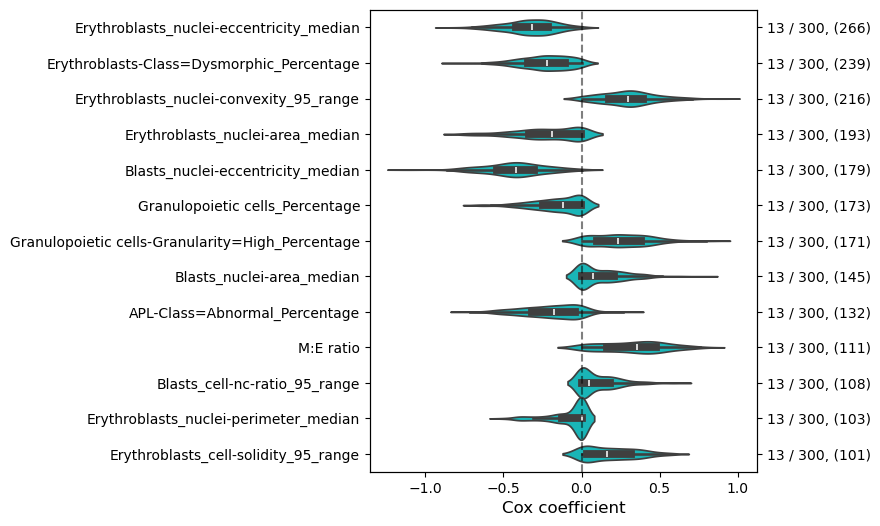

In [36]:
min_included = 100

feat_dict = {}
for iter_i in np.arange(enet_iters):
    for cv in np.arange(3):
        f_coefs = enet_results[iter_i]["estimator"][cv].best_estimator_.steps[3][1].estimator.coef_
        f_names = enet_results[iter_i]["estimator"][cv].best_estimator_[:-1].get_feature_names_out()
        f_names = [x.split("__")[-1] for x in f_names]

        f_c_pairs = list((k, np.round(v[0], 4)) for k, v in zip(f_names, f_coefs))

        for k, v in f_c_pairs:
            if k in feat_dict:
                feat_dict[k].append(v)
            else:
                feat_dict[k] = [v]

# Only plot features that have at least min_included nonzero coefficients
common_feat_dict = {feat: coefs for (feat, coefs) in feat_dict.items() if np.sum(np.array(coefs) != 0) >= min_included}

# Define feature order as the number of times the feature was picked to be included in the models
feat_order = np.array(list(common_feat_dict.keys()))[np.argsort([np.sum([x != 0 for x in coefs]) for coefs in common_feat_dict.values()])][::-1]

fig, ax = plt.subplots()
fig.set_figwidth(5)
fig.set_figheight(6)

sns.violinplot(
    common_feat_dict,
    ax=ax,
    order=feat_order,
    orient="h",
    color="darkturquoise",
    width=1.2
)

ax.axvline(x=0, color="black", linestyle="--", alpha=0.50)
ax.set_xlabel("Cox coefficient", size=12)

ax2 = ax.twinx()
ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim())

ax2.set_yticklabels([f"{len(common_feat_dict)} / {enet_iters*3}, ({np.sum(np.array(common_feat_dict[feat]) != 0)})" for feat in feat_order])
ax2.yaxis.grid(False)

Unsurprisingly, as the data is effectively random, we do not see any features being particularly commonly chosen by the cross-validation routine over others